### convLSTM


##### Importing libraries


In [44]:
import numpy as np
import pandas as pd
from kerastuner import HyperModel, RandomSearch
from keras.models import Sequential
from keras.layers import ConvLSTM2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from keras.models import Sequential
from keras.layers import ConvLSTM2D, Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

##### importing the data 

In [45]:
test_data = pd.read_pickle("test_data.pkl")
train_data = pd.read_pickle("train_data.pkl")

##### importing the data 

In [46]:
scaler = MinMaxScaler()
train_data = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)
test_data = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)

##### Reshaping the Data

In [47]:
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length].values)
        y.append(data.iloc[i+seq_length].values)
    return np.array(x), np.array(y)
sequence_length = 20
x_train, y_train = create_sequences(train_data, sequence_length)
x_test, y_test = create_sequences(test_data, sequence_length)
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2], 1)

##### Building the model

In [48]:


class ConvLSTMHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape
    def build(self, hp):
        model = Sequential()
        model.add(ConvLSTM2D(filters=hp.Int('filters', min_value=16, max_value=64, step=16), kernel_size=(1, 2), return_sequences=False, input_shape=self.input_shape))
        model.add(Flatten())
        model.add(Dense(train_data.shape[1]))
        model.compile(optimizer='adam', loss='mse')
        return model

##### Tuning the hyperparameters

In [49]:
hypermodel = ConvLSTMHyperModel(input_shape=(1, sequence_length, train_data.shape[1], 1))
tuner = RandomSearch(hypermodel, objective='val_loss', max_trials=3, seed=42)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
tuner.search(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hyperparameters)

INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit


##### Runing the model

In [50]:
history = best_model.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])
predictions = best_model.predict(x_test)

Epoch 1/100
1023/1023 [==============================] - 91s 86ms/step - loss: 0.0402 - val_loss: 0.0398
Epoch 2/100
1023/1023 [==============================] - 83s 81ms/step - loss: 0.0392 - val_loss: 0.0396
Epoch 3/100
1023/1023 [==============================] - 80s 79ms/step - loss: 0.0392 - val_loss: 0.0396
Epoch 4/100
1023/1023 [==============================] - 80s 79ms/step - loss: 0.0391 - val_loss: 0.0396
Epoch 5/100
1023/1023 [==============================] - 81s 79ms/step - loss: 0.0391 - val_loss: 0.0394
Epoch 6/100
1023/1023 [==============================] - 81s 79ms/step - loss: 0.0390 - val_loss: 0.0396
Epoch 7/100
1023/1023 [==============================] - 82s 80ms/step - loss: 0.0390 - val_loss: 0.0395
Epoch 8/100
639/639 [==============================] - 7s 10ms/step


##### Results

In [51]:
print("Best model architecture:")
best_model.summary()
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")
residuals = y_test - predictions
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)
anomalies = np.where(np.abs(residuals - mean_residual) > 3*std_residual)[0]
print(f"Number of Anomalies: {len(anomalies)}")

Best model architecture:
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_5 (ConvLSTM2D)  (None, 20, 24, 16)        2240      
                                                                 
 flatten_5 (Flatten)         (None, 7680)              0         
                                                                 
 dense_7 (Dense)             (None, 25)                192025    
                                                                 
Total params: 194,265
Trainable params: 194,265
Non-trainable params: 0
_________________________________________________________________
Mean Squared Error: 0.03924959320127838
Mean Absolute Error: 0.11545636552723418
R^2 Score: -5.68352791656794
Number of Anomalies: 7564


##### Visualizations

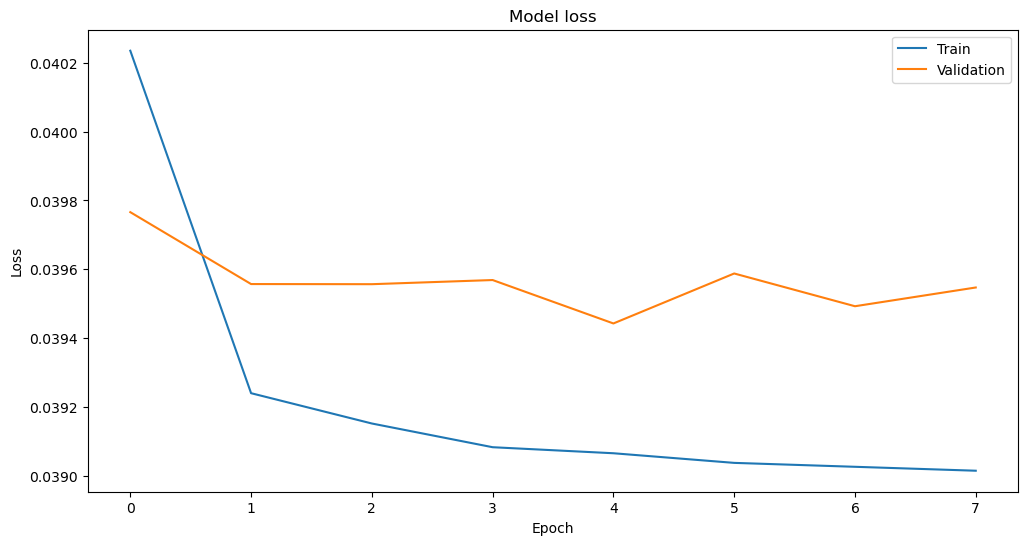

In [52]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

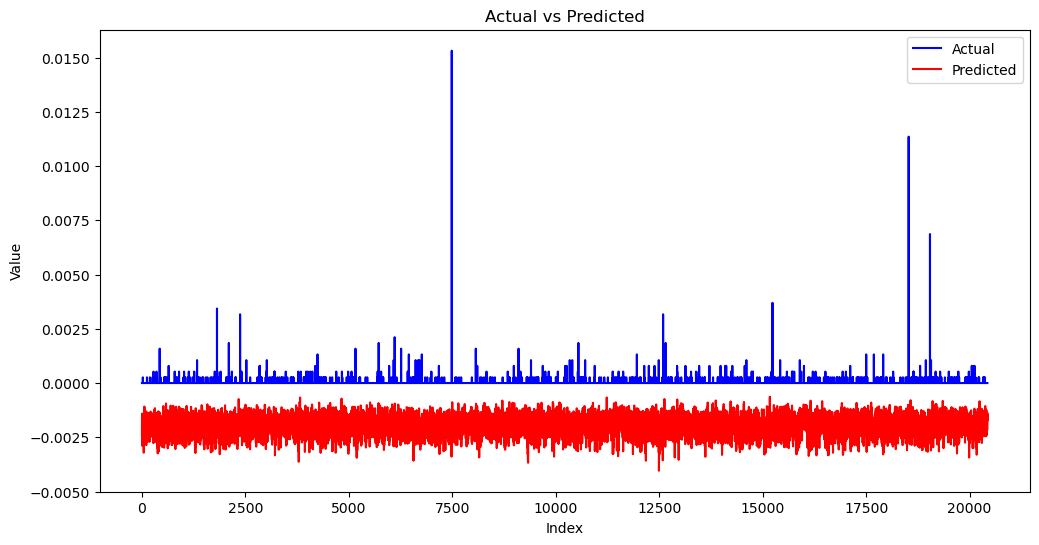

In [53]:
feature_idx = 2
plt.figure(figsize=(12,6))
plt.plot(y_test[:, feature_idx], color='blue', label='Actual')
plt.plot(predictions[:, feature_idx], color='red', label='Predicted')
plt.title('Actual vs Predicted')
plt.ylabel('Value')
plt.xlabel('Index')
plt.legend(loc='upper right')
plt.show()

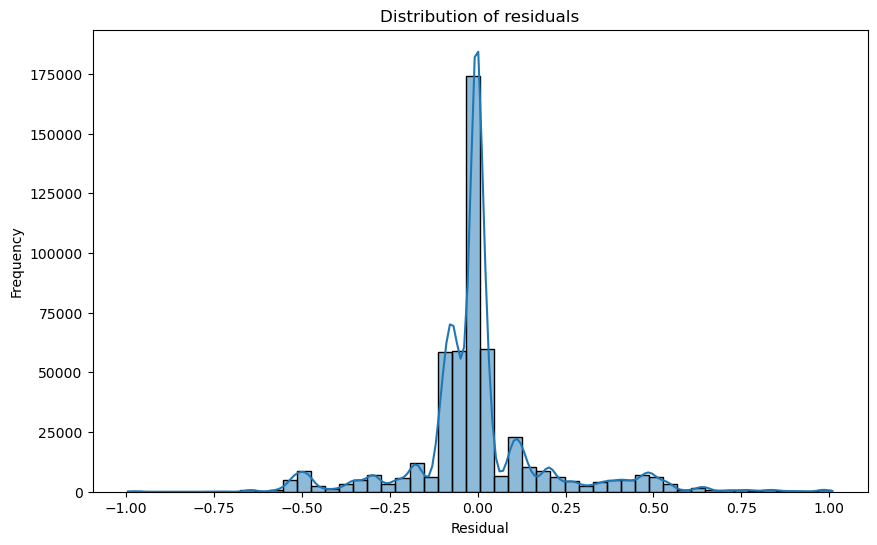

In [34]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals.flatten(), bins=50, kde=True)
plt.title('Distribution of residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

In [39]:
# Reading Data
df = pd.read_pickle("my_labeled_data.pkl")
# Prepare data
X = df.drop(columns=['anomaly'])
y = df['anomaly']
#normalize Data
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Reshape
X_train = np.reshape(X_train, (X_train.shape[0], 1, 1, 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, 1, 1, X_test.shape[1]))
# Define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3], X_train.shape[4]), data_format='channels_last'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
# Fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
# Make predictions
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Epoch 1/100
409/409 [==============================] - 5s 5ms/step - loss: 0.1244 - accuracy: 0.9850 - val_loss: 0.0625 - val_accuracy: 0.9847
Epoch 2/100
409/409 [==============================] - 2s 4ms/step - loss: 0.0556 - accuracy: 0.9875 - val_loss: 0.0550 - val_accuracy: 0.9847
Epoch 3/100
409/409 [==============================] - 2s 4ms/step - loss: 0.0487 - accuracy: 0.9880 - val_loss: 0.0461 - val_accuracy: 0.9869
Epoch 4/100
409/409 [==============================] - 2s 4ms/step - loss: 0.0413 - accuracy: 0.9890 - val_loss: 0.0394 - val_accuracy: 0.9878
Epoch 5/100
409/409 [==============================] - 2s 5ms/step - loss: 0.0367 - accuracy: 0.9900 - val_loss: 0.0348 - val_accuracy: 0.9887
Epoch 6/100
409/409 [==============================] - 2s 4ms/step - loss: 0.0323 - accuracy: 0.9911 - val_loss: 0.0317 - val_accuracy: 0.9896
Epoch 7/100
409/409 [==============================] - 2s 4ms/step - loss: 0.0282 - accuracy: 0.9917 - val_loss: 0.0318 - val_accuracy: 0.9902

In [40]:
# precision, recall, f1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f"True Positives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

Precision: 0.967741935483871
Recall: 0.6
F1-Score: 0.7407407407407407
True Positives: 30
True Negatives: 4040
False Positives: 1
False Negatives: 20


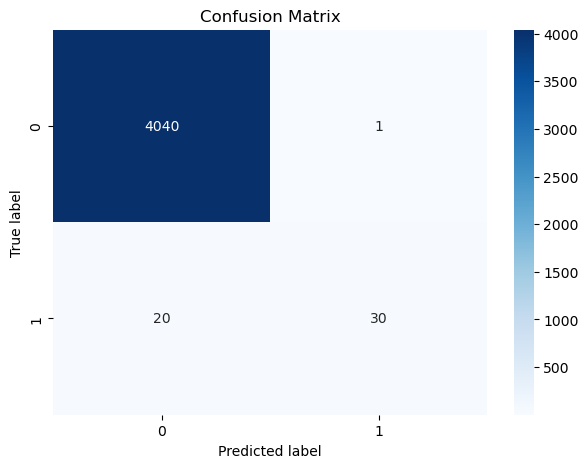

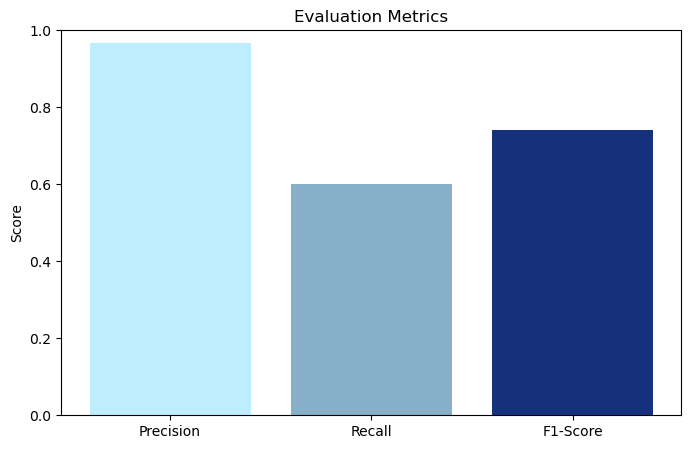

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()
plt.figure(figsize=(8, 5))
plt.bar(['Precision', 'Recall', 'F1-Score'], [precision, recall, f1], color=['#BDEDFF', '#87AFC7', '#15317E'])
plt.title('Evaluation Metrics')
plt.ylabel('Score')
plt.ylim([0.0, 1.0])
plt.show()

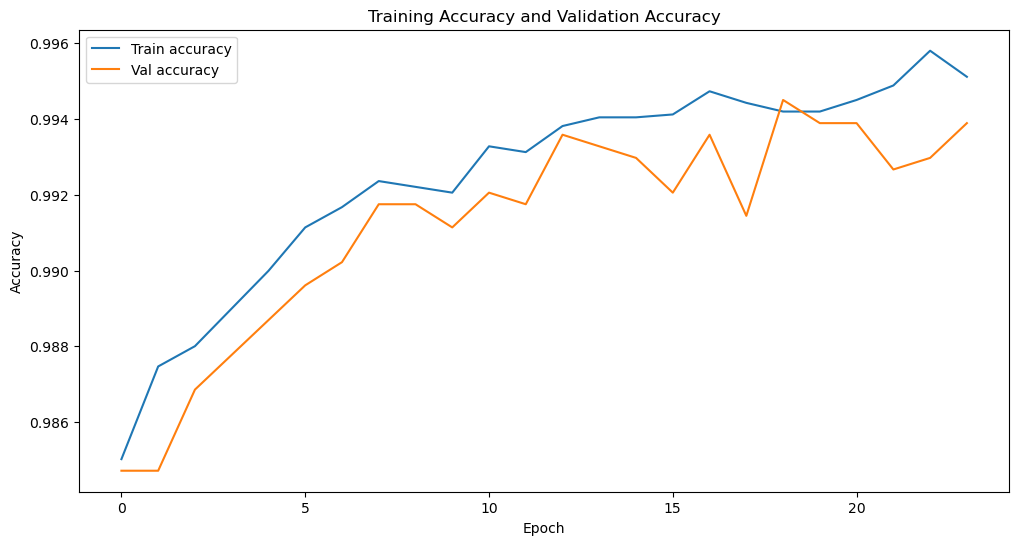

In [42]:
plt.figure(figsize=(12,6))
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.title('Training Accuracy and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()